In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import argparse
import numpy as np
import os
from os.path import join
from pprint import pprint
from pprint import pformat
import sys
import tensorflow as tf
import tensorflow.contrib.slim as slim
import time
import tflearn
from tqdm import tqdm
import json

sys.path.append('../')
from batch_generator import BatchGenerator
from data_utils import ROOT_DIR
from data_utils import slice_image_fixed_tiles
from data_utils import create_val_test_df
import net_spec
from net_spec import SegPlusRegNet
from net_config import calc_test_metrics

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
args_path = ('/export/home/asanakoy/workspace/kaggle/noaa/checkpoints/'
'inception_resnet_v2_tile299_avgpool_fc256_aug2_fullscaleaug-0.5-1.5_2_coordsv0/args.json')

class dump_into_namespace:
    def __init__(self, d):
        self.__dict__.update(d)
        
with open(args_path) as f:
    args = dump_into_namespace(json.load(f))
del args.suf
args.__dict__
args.batch_size = 8

sess = None

In [5]:
if sess:
    sess.close()
tf.reset_default_graph()
snapshot_path = ('/export/home/asanakoy/workspace/noaa/checkpoints/'
'inception_resnet_v2_tile299_avgpool_fc256_aug2_fullscaleaug-0.5-1.5_coordsv0/'
'checkpoint-95000')

with tf.variable_scope('input'):
    input_images = tflearn.input_data(shape=[None, args.tile_size, args.tile_size, 3],
                                                   name='input_images_pl')
    input_images = net_spec.preprocessing_fn_map[args.model](input_images)
    input_heatmaps = None
    input_gt_counts = None
    is_training_pl = tf.placeholder(tf.bool)

net = SegPlusRegNet(input_images, input_heatmaps, input_gt_counts,
                     is_training_pl=is_training_pl,
                     input_image_ids=None,
                     use_regression_loss=False,
                     use_segmentation_loss=False,
                     extra_fc_size=args.extra_fc,
                     net_name=args.model,
                     should_create_summaries=False,
                     global_pool=args.pool)

        
config = tflearn.init_graph(num_cores=0, gpu_memory_fraction=None,
                                    log_device=False, seed=42)
net.sess = tf.Session(config=config)
sess = net.sess
net.sess.run(tf.local_variables_initializer())
net.sess.run(tf.global_variables_initializer())

init_fn = slim.assign_from_checkpoint_fn(
        snapshot_path,
        slim.get_model_variables(),
        ignore_missing_vars=True)
init_fn(net.sess)

Create Net. Use ReLU after heatmaps=False
INFO:tensorflow:Restoring parameters from /export/home/asanakoy/workspace/noaa/checkpoints/inception_resnet_v2_tile299_avgpool_fc256_aug2_fullscaleaug-0.5-1.5_coordsv0/checkpoint-95000


In [6]:
# [tensor.name for tensor in tf.get_default_graph().as_graph_def().node if tensor.name.startswith('input')]

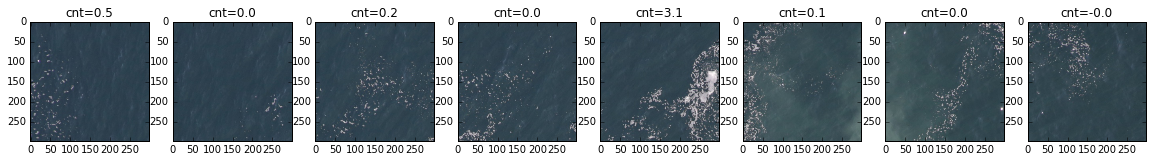

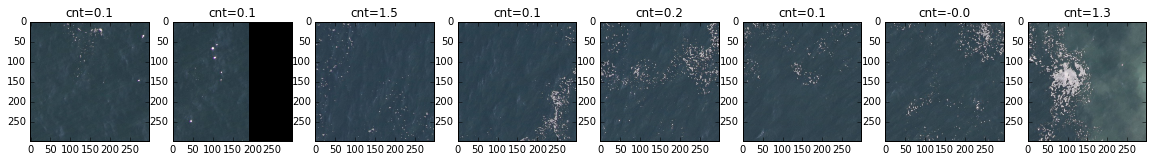

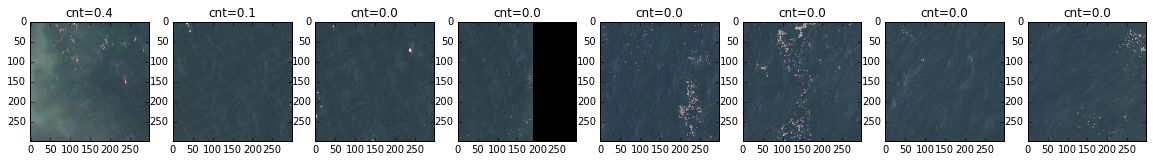

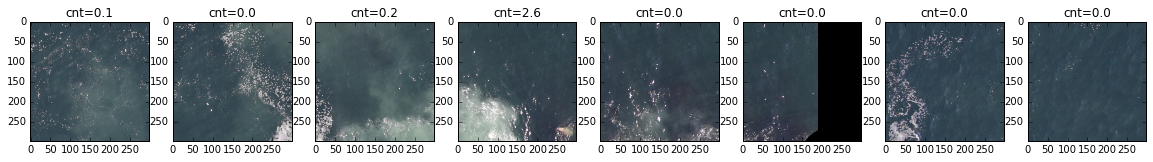

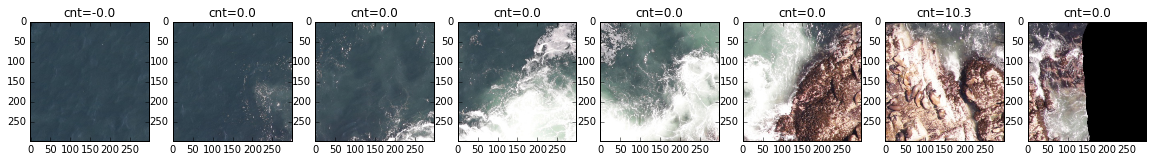

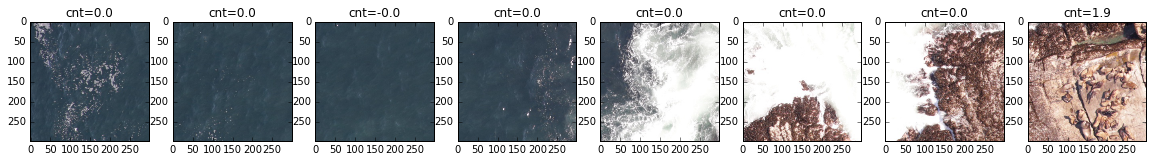

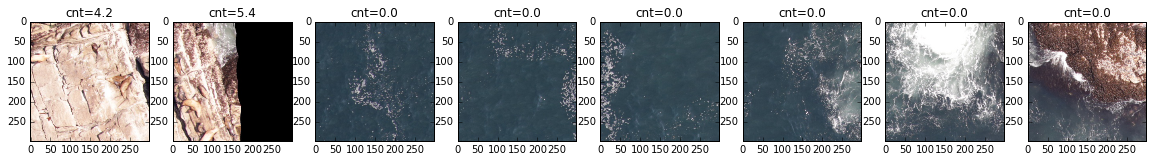

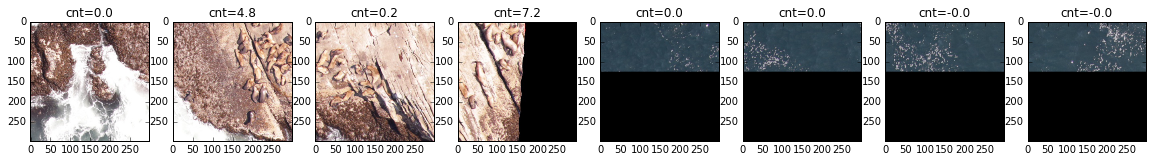

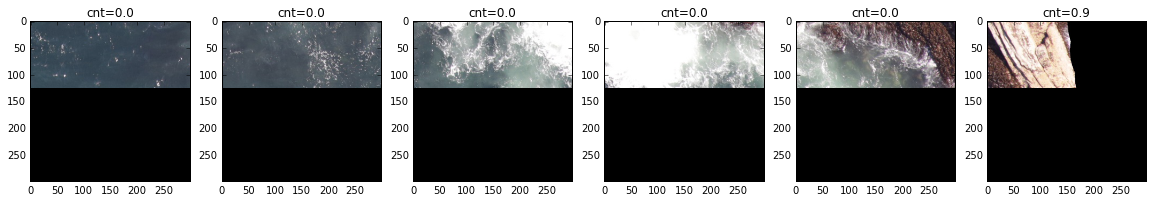

(70, 5)
Total obj: [  1.8033843    1.61025834  18.15320015  17.61636353   6.98631239]
Total: 46.1695


In [7]:
import scipy 
img_id = 14458
img = scipy.misc.imread(join(ROOT_DIR, 'Test/black_0.5/{}.jpg'.format(img_id)))
tiles = slice_image_fixed_tiles(img, args.tile_size, pad_value=0)

batch_size = 8

all_counts = list()
for i in xrange(0, len(tiles), batch_size):
    batch = tiles[i:i + batch_size, ...]
    feed_dict = {
        net.input_images_pl: batch,
        net.is_training_pl: 'test'
    }
    obj_counts = net.sess.run(net.obj_counts,  feed_dict=feed_dict)
    all_counts.append(obj_counts)
    
    obj_counts = obj_counts.sum(axis=1)
    plt.figure(figsize=(20,4))
    for j in xrange(len(batch)):
        plt.subplot(1, len(batch), j + 1)
        plt.imshow(batch[j])
        plt.title('cnt={:.1f}'.format(obj_counts[j]))
        plt.grid(False)
    plt.show()
#     print obj_counts
all_counts = np.vstack(all_counts)
print all_counts.shape
all_counts = np.array(all_counts).sum(axis=0)
print 'Total obj:', all_counts
print 'Total:', np.array(all_counts).sum()